In [33]:
%load_ext autoreload
%autoreload 2

import pathlib
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import pandas as pd
import sys, os
from pathlib import Path
import nibabel as nib
from matplotlib.colors import ListedColormap

# Project-specific imports
sys.path.append(os.path.abspath("src"))
from train import Trainer
from utils import set_global_seed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
EXPERIMENT = "exp20_nnunet"
BASE_DIR = Path("results") / EXPERIMENT
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
MODEL_DIR = BASE_DIR / "models"
LOG_DIR = BASE_DIR / "logs"

In [ ]:
# Ensure directories exist
for d in (BASE_DIR, CHECKPOINT_DIR, MODEL_DIR, LOG_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Training configuration
config = {
    "experiment": EXPERIMENT,
    "data_dir": "/datasets/tdt4265/mic/open/HNTS-MRG",
    "batch_size": 3,
    "learning_rate": 1e-3,
    "early_stop_count": 15,
    "epochs": 200,
    "in_channels": 1,
    "out_channels": 3,
}

# Save config to YAML
with open(BASE_DIR / "config.yaml", "w") as f:
    yaml.dump(config, f)

# %% [markdown]
## Initialize Trainer and Set Random Seed

# Reproducibility
set_global_seed(0)

# Create trainer instance
trainer = Trainer(
    data_dir=config["data_dir"],
    batch_size=config["batch_size"],
    learning_rate=config["learning_rate"],
    early_stop_count=config["early_stop_count"],
    epochs=config["epochs"],
    in_channels=config["in_channels"],
    out_channels=config["out_channels"],
    checkpoint_dir=CHECKPOINT_DIR,
)

In [ ]:
trainer.train()

In [45]:
def load_history(path: Path) -> dict:
    """
    Load JSON history from a given file path.
    """
    with open(path, 'r') as f:
        return json.load(f)


def plot_metrics(history: dict, metrics: list, figsize=(8, 5)):
    """
    Plot specified metrics from a history dict.
    `metrics` is a list of tuples: (stage, metric_name, label, color).
    """
    plt.figure(figsize=figsize)
    for stage, name, label, color in metrics:
        data = history[stage][name]
        steps = sorted(map(int, data.keys()))
        values = [data[str(s)] for s in steps]
        plt.plot(steps, values, label=label, color=color)

    plt.xlabel("Global Step")
    plt.ylabel("Metric Value")
    plt.title("Training Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

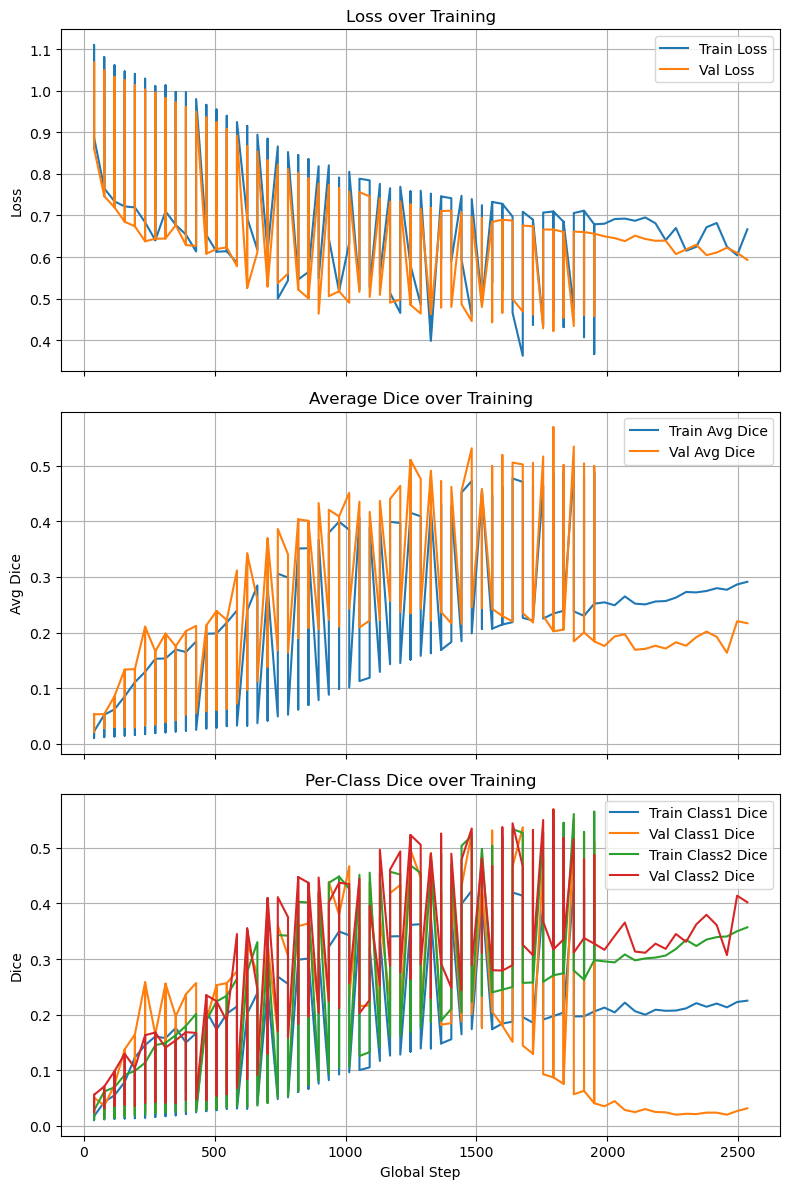

At globalstep 2535.0: Train Loss = 0.667, Val Loss = 0.593
Train Avg Dice = 0.291, Val Avg Dice = 0.217
Train Class1 Dice = 0.225, Val Class1 Dice = 0.032
Train Class2 Dice = 0.357, Val Class2 Dice = 0.402


In [46]:
# 1) Collect records from all history files including loss, avg dice, and per-class dice
records = []
for fp in sorted(LOG_DIR.glob("history_*.json")):
    h = load_history(fp)
    for step_str in h["validation"]["dice"]:
        step = int(step_str)
        records.append({
            "step": step,
            # Loss
            "train_loss": h["train"]["loss"][step_str],
            "val_loss": h["validation"]["loss"][step_str],
            # Average Dice
            "train_dice": h["train"]["dice"][step_str],
            "val_dice": h["validation"]["dice"][step_str],
            # Per-class Dice
            "train_dice_class1": h["train"].get("dice_class1", {})[step_str],
            "val_dice_class1": h["validation"].get("dice_class1", {})[step_str],
            "train_dice_class2": h["train"].get("dice_class2", {})[step_str],
            "val_dice_class2": h["validation"].get("dice_class2", {})[step_str],
        })

df = pd.DataFrame(records).sort_values("step")

# 2) Plot Loss, Avg Dice, and Per-Class Dice over Training
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Loss
axes[0].plot(df.step, df.train_loss, label="Train Loss")
axes[0].plot(df.step, df.val_loss,   label="Val Loss")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss over Training")
axes[0].legend()
axes[0].grid(True)

# Average Dice
axes[1].plot(df.step, df.train_dice, label="Train Avg Dice")
axes[1].plot(df.step, df.val_dice,   label="Val Avg Dice")
axes[1].set_ylabel("Avg Dice")
axes[1].set_title("Average Dice over Training")
axes[1].legend()
axes[1].grid(True)

# Per-Class Dice
axes[2].plot(df.step, df.train_dice_class1, label="Train Class1 Dice")
axes[2].plot(df.step, df.val_dice_class1,   label="Val Class1 Dice")
axes[2].plot(df.step, df.train_dice_class2, label="Train Class2 Dice")
axes[2].plot(df.step, df.val_dice_class2,   label="Val Class2 Dice")
axes[2].set_xlabel("Global Step")
axes[2].set_ylabel("Dice")
axes[2].set_title("Per-Class Dice over Training")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 3) Report final metrics
final = df.iloc[-1]
print(
    f"At globalstep {final.step}:"
    f" Train Loss = {final.train_loss:.3f}, Val Loss = {final.val_loss:.3f}\n"
    f"Train Avg Dice = {final.train_dice:.3f}, Val Avg Dice = {final.val_dice:.3f}\n"
    f"Train Class1 Dice = {final.train_dice_class1:.3f}, Val Class1 Dice = {final.val_dice_class1:.3f}\n"
    f"Train Class2 Dice = {final.train_dice_class2:.3f}, Val Class2 Dice = {final.val_dice_class2:.3f}"
)

In [40]:
def load_nifti(file_path):
    return nib.load(file_path).get_fdata()

def visualize_slices(image_path, label_path, prediction_path, slice_idx=None):
    image = load_nifti(image_path)
    label = load_nifti(label_path)
    prediction = load_nifti(prediction_path)

    if slice_idx is None:
        slice_idx = image.shape[-1] // 2

    if label.ndim == 4:
        label = np.argmax(label, axis=0)
    if prediction.ndim == 4:
        prediction = np.argmax(prediction, axis=0)

    def class_distribution(arr):
        counts = np.bincount(arr.flatten().astype(int), minlength=3)
        return tuple(int(c) for c in counts)

    print("Label class distribution:", class_distribution(label))
    print("Prediction class distribution:", class_distribution(prediction))

    # Define class colors
    class_colors = ["blue", "green", "red"]
    class_labels = ["Background", "GTVp", "GTVn"]
    cmap = ListedColormap(class_colors)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

    # MRI image
    axes[0].imshow(image[:, :, slice_idx], cmap="gray")
    axes[0].set_title("MRI Scan")
    axes[0].axis("off")

    # Ground Truth
    axes[1].imshow(image[:, :, slice_idx], cmap="gray")
    axes[1].imshow(label[:, :, slice_idx], cmap=cmap, alpha=0.5, vmin=0, vmax=2)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # Prediction
    axes[2].imshow(image[:, :, slice_idx], cmap="gray")
    im_pred = axes[2].imshow(prediction[:, :, slice_idx], cmap=cmap, alpha=0.5, vmin=0, vmax=2)
    axes[2].set_title("Model Prediction")
    axes[2].axis("off")

    # Add colorbar in a separate axis
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im_pred, cax=cbar_ax, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(class_labels)
    cbar.set_label("Class Index")

    plt.subplots_adjust(wspace=0.05)
    plt.show()

Label class distribution: (1751055, 3956, 14461)
Prediction class distribution: (1749317, 9458, 10697)


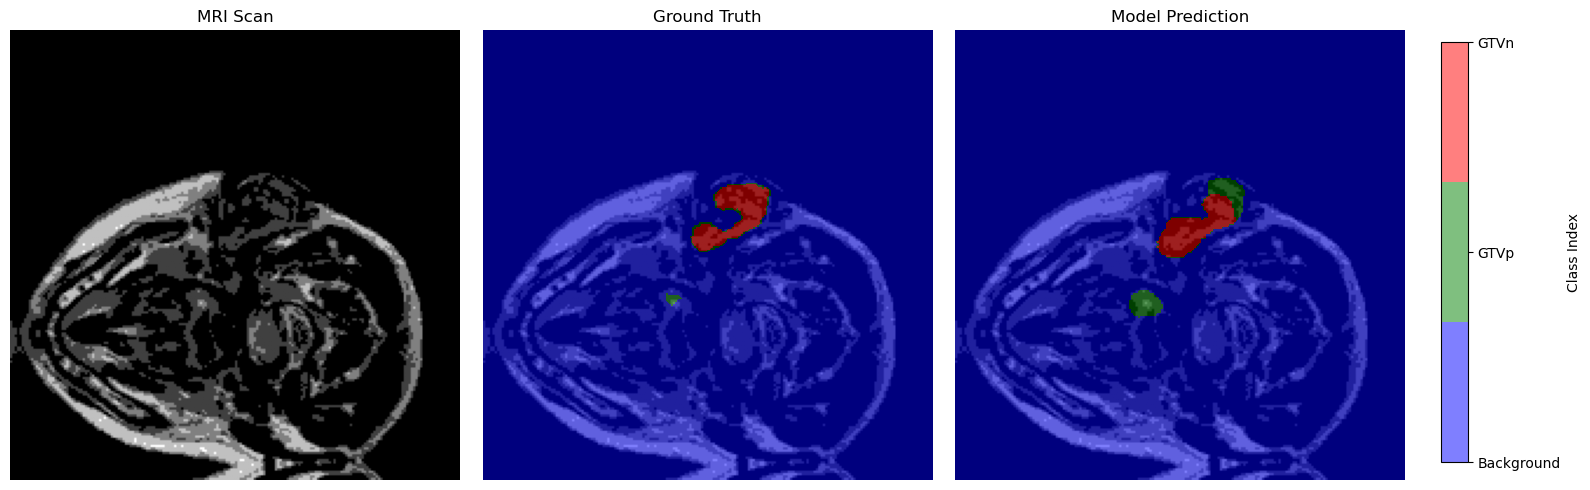

In [41]:
# Set file paths (adjust paths as needed)
image_path = "results/exp20_nnunet/predictions/image_2.nii.gz"
label_path = "results/exp20_nnunet/predictions/label_2.nii.gz"
prediction_path = "results/exp20_nnunet/predictions/prediction_2.nii.gz"

# Visualize a specific slice (e.g., slice 50)
visualize_slices(image_path, label_path, prediction_path, slice_idx=30)